<a href="https://colab.research.google.com/github/bdunn20/book_code/blob/main/football_analytics/Ch_6_Poisson_Regression_and_Passing_TD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 6: Using Data Science for Sports Betting: Poisson Regression & Passing TDs

### Import packages

In [ ]:
! pip install nfl_data_py

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.3 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13187 sha256=b2236d69a183ae9fdcdadf953e77338f2c58076ed12884adecbc5f8d8ee3e239
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py


In [ ]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

### Import data

In [ ]:
seasons = range(2016, 2023 + 1)
pbp_py = nfl.import_pbp_data(seasons)

pbp_py_pass = pbp_py.query('passer_id.notnull()').reset_index()

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


### Poisson

In [ ]:
# replace NULL or NA values with 0 for pass_touchdowns
pbp_py_pass.loc[pbp_py_pass.pass_touchdown.isnull(), "pass_touchdown"] = 0

# set plays without a passer or passer_id to none
pbp_py_pass.loc[pbp_py_pass.passer.isnull(), "passer"] = 'none'
pbp_py_pass.loc[pbp_py_pass.passer_id.isnull(), "passer_id"] = 'none'

# aggregate by season, week, passer_id and passer
# to calc the # of passes and pass_td per week
pbp_py_pass_td_y = pbp_py_pass.groupby(["season", "week", "passer_id", "passer"]).agg({"pass_touchdown": ["sum"], "total_line": ["count", "mean"]})

pbp_py_pass_td_y.columns = list(map("_".join, pbp_py_pass_td_y.columns))
pbp_py_pass_td_y.reset_index(inplace=True)
pbp_py_pass_td_y.rename(columns={"pass_touchdown_sum": "pass_td_y", "total_line_mean": "total_line", "total_line_count": "n_passes"}, inplace=True)

# filter to exclude players w/ < 10 plays as passer for each week
pbp_py_pass_td_y = pbp_py_pass_td_y.query("n_passes >= 10")

# calc # of pass TD per QB per week
pbp_py_pass_td_y.groupby("pass_td_y").agg({"n_passes": "count"})

,n_passes
pass_td_y,
0.0,1026
1.0,1461
2.0,1163
3.0,549
4.0,205
5.0,33
6.0,4


In [ ]:
pbp_py_pass_td_y.describe()

,season,week,pass_td_y,n_passes,total_line
count,4441.000000,4441.000000,4441.000000,4441.000000,4441.000000
mean,2019.472416,9.446971,1.450799,38.710426,45.473316
std,2.257763,5.316254,1.158157,10.589043,4.478580
min,2016.000000,1.000000,0.000000,10.000000,30.000000
25%,2017.000000,5.000000,1.000000,32.000000,42.500000
50%,2020.000000,9.000000,1.000000,39.000000,45.000000
75%,2021.000000,14.000000,2.000000,46.000000,48.500000
max,2023.000000,22.000000,6.000000,84.000000,63.500000


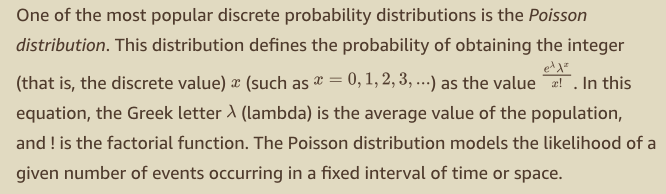

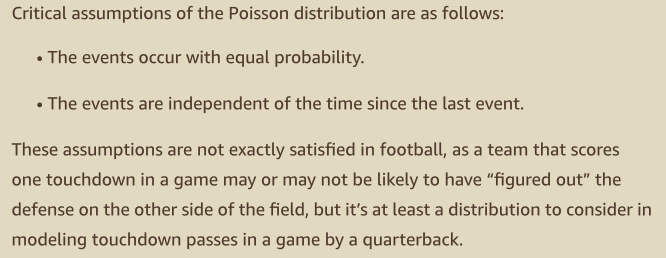

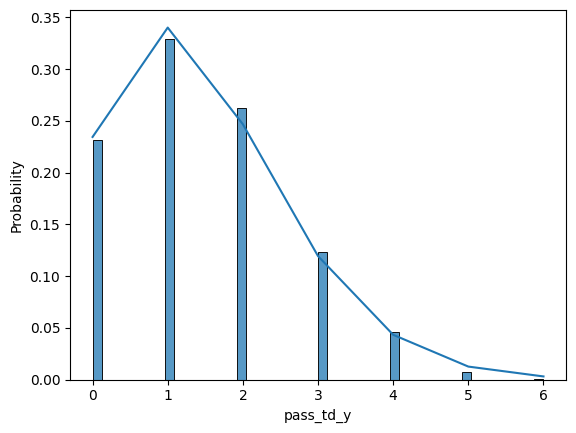

In [ ]:
# see if a Poisson is reasonable w/ a bar graph of frequencies
pass_td_y_mean_py = pbp_py_pass_td_y.pass_td_y.mean()

plot_pos_py = pd.DataFrame({"x": range(0, 7), "expected": [poisson.pmf(x, pass_td_y_mean_py) for x in range(0, 7)]})

sns.histplot(pbp_py_pass_td_y["pass_td_y"], stat="probability")
plt.plot(plot_pos_py.x, plot_pos_py.expected)
plt.show()

In the above graph, the bar chart shows the observed probability of x pass TD in a game. The line shows the theoretical expected values from the Poisson distribution. The Poisson distribution seems to slightly overestimate the likelihood of zero or one TD pass, slightly underestimate the likelihood of 2, 3 or 4 TD passes.

For the purposes of this learning exercise, we will assume a Poisson distribution is sufficient to handicap TD pass probability.

### Individual Player Markets & Modeling

For this section, we will use the following as factors:
- total
  - the # of pts expected by the betting markets to be scored
- mean # of TD passes by QB of interest over prev 2 seasons

In [ ]:
# pass td >= 10 per week
pbp_py_pass_td_y_geq10 = pbp_py_pass_td_y.query("n_passes >= 10")

# avg td passes for each QB for prev season & current season up to current game
x_py = pd.DataFrame()

for season_idx in range(2017, 2023 + 1):
  for week_idx in range(1, 22 + 1):
    week_calc_py = (pbp_py_pass_td_y_geq10.query("(season == " + str(season_idx - 1) + ") |" + "(season == " + str(season_idx) + "&" + "week < " + str(week_idx) + ")")\
      .groupby(["passer_id", "passer"]).agg({"pass_td_y": ["count", "mean"]}))
    week_calc_py.columns = list(map("_".join, week_calc_py.columns))
    week_calc_py.reset_index(inplace=True)
    week_calc_py.rename(columns={"pass_td_y_count": "n_games",
                                 "pass_td_y_mean": "pass_td_rate"},
                        inplace=True)
    week_calc_py["season"] = season_idx
    week_calc_py["week"] = week_idx
    x_py = pd.concat([x_py, week_calc_py])

In [ ]:
pbp_py_pass_td_y_geq10.head()

,season,week,passer_id,passer,pass_td_y,n_passes,total_line
0,2016,1,00-0020531,D.Brees,4.0,45,50.0
1,2016,1,00-0020679,S.Hill,0.0,35,40.0
2,2016,1,00-0021429,C.Palmer,2.0,42,44.5
3,2016,1,00-0022803,E.Manning,3.0,31,47.5
4,2016,1,00-0022924,B.Roethlisberger,3.0,38,49.0


In [ ]:
x_py.query('passer == "P.Mahomes"').tail()

,passer_id,passer,n_games,pass_td_rate,season,week
33,00-0033873,P.Mahomes,34,2.147059,2023,18
33,00-0033873,P.Mahomes,34,2.147059,2023,19
33,00-0033873,P.Mahomes,34,2.147059,2023,20
33,00-0033873,P.Mahomes,34,2.147059,2023,21
33,00-0033873,P.Mahomes,34,2.147059,2023,22


In [ ]:
# create response variable using merge
pbp_py_pass_td_y_geq10 = pbp_py_pass_td_y_geq10.query("season != 2016").merge(
    x_py, on=["season", "week", "passer_id", "passer"], how="inner")

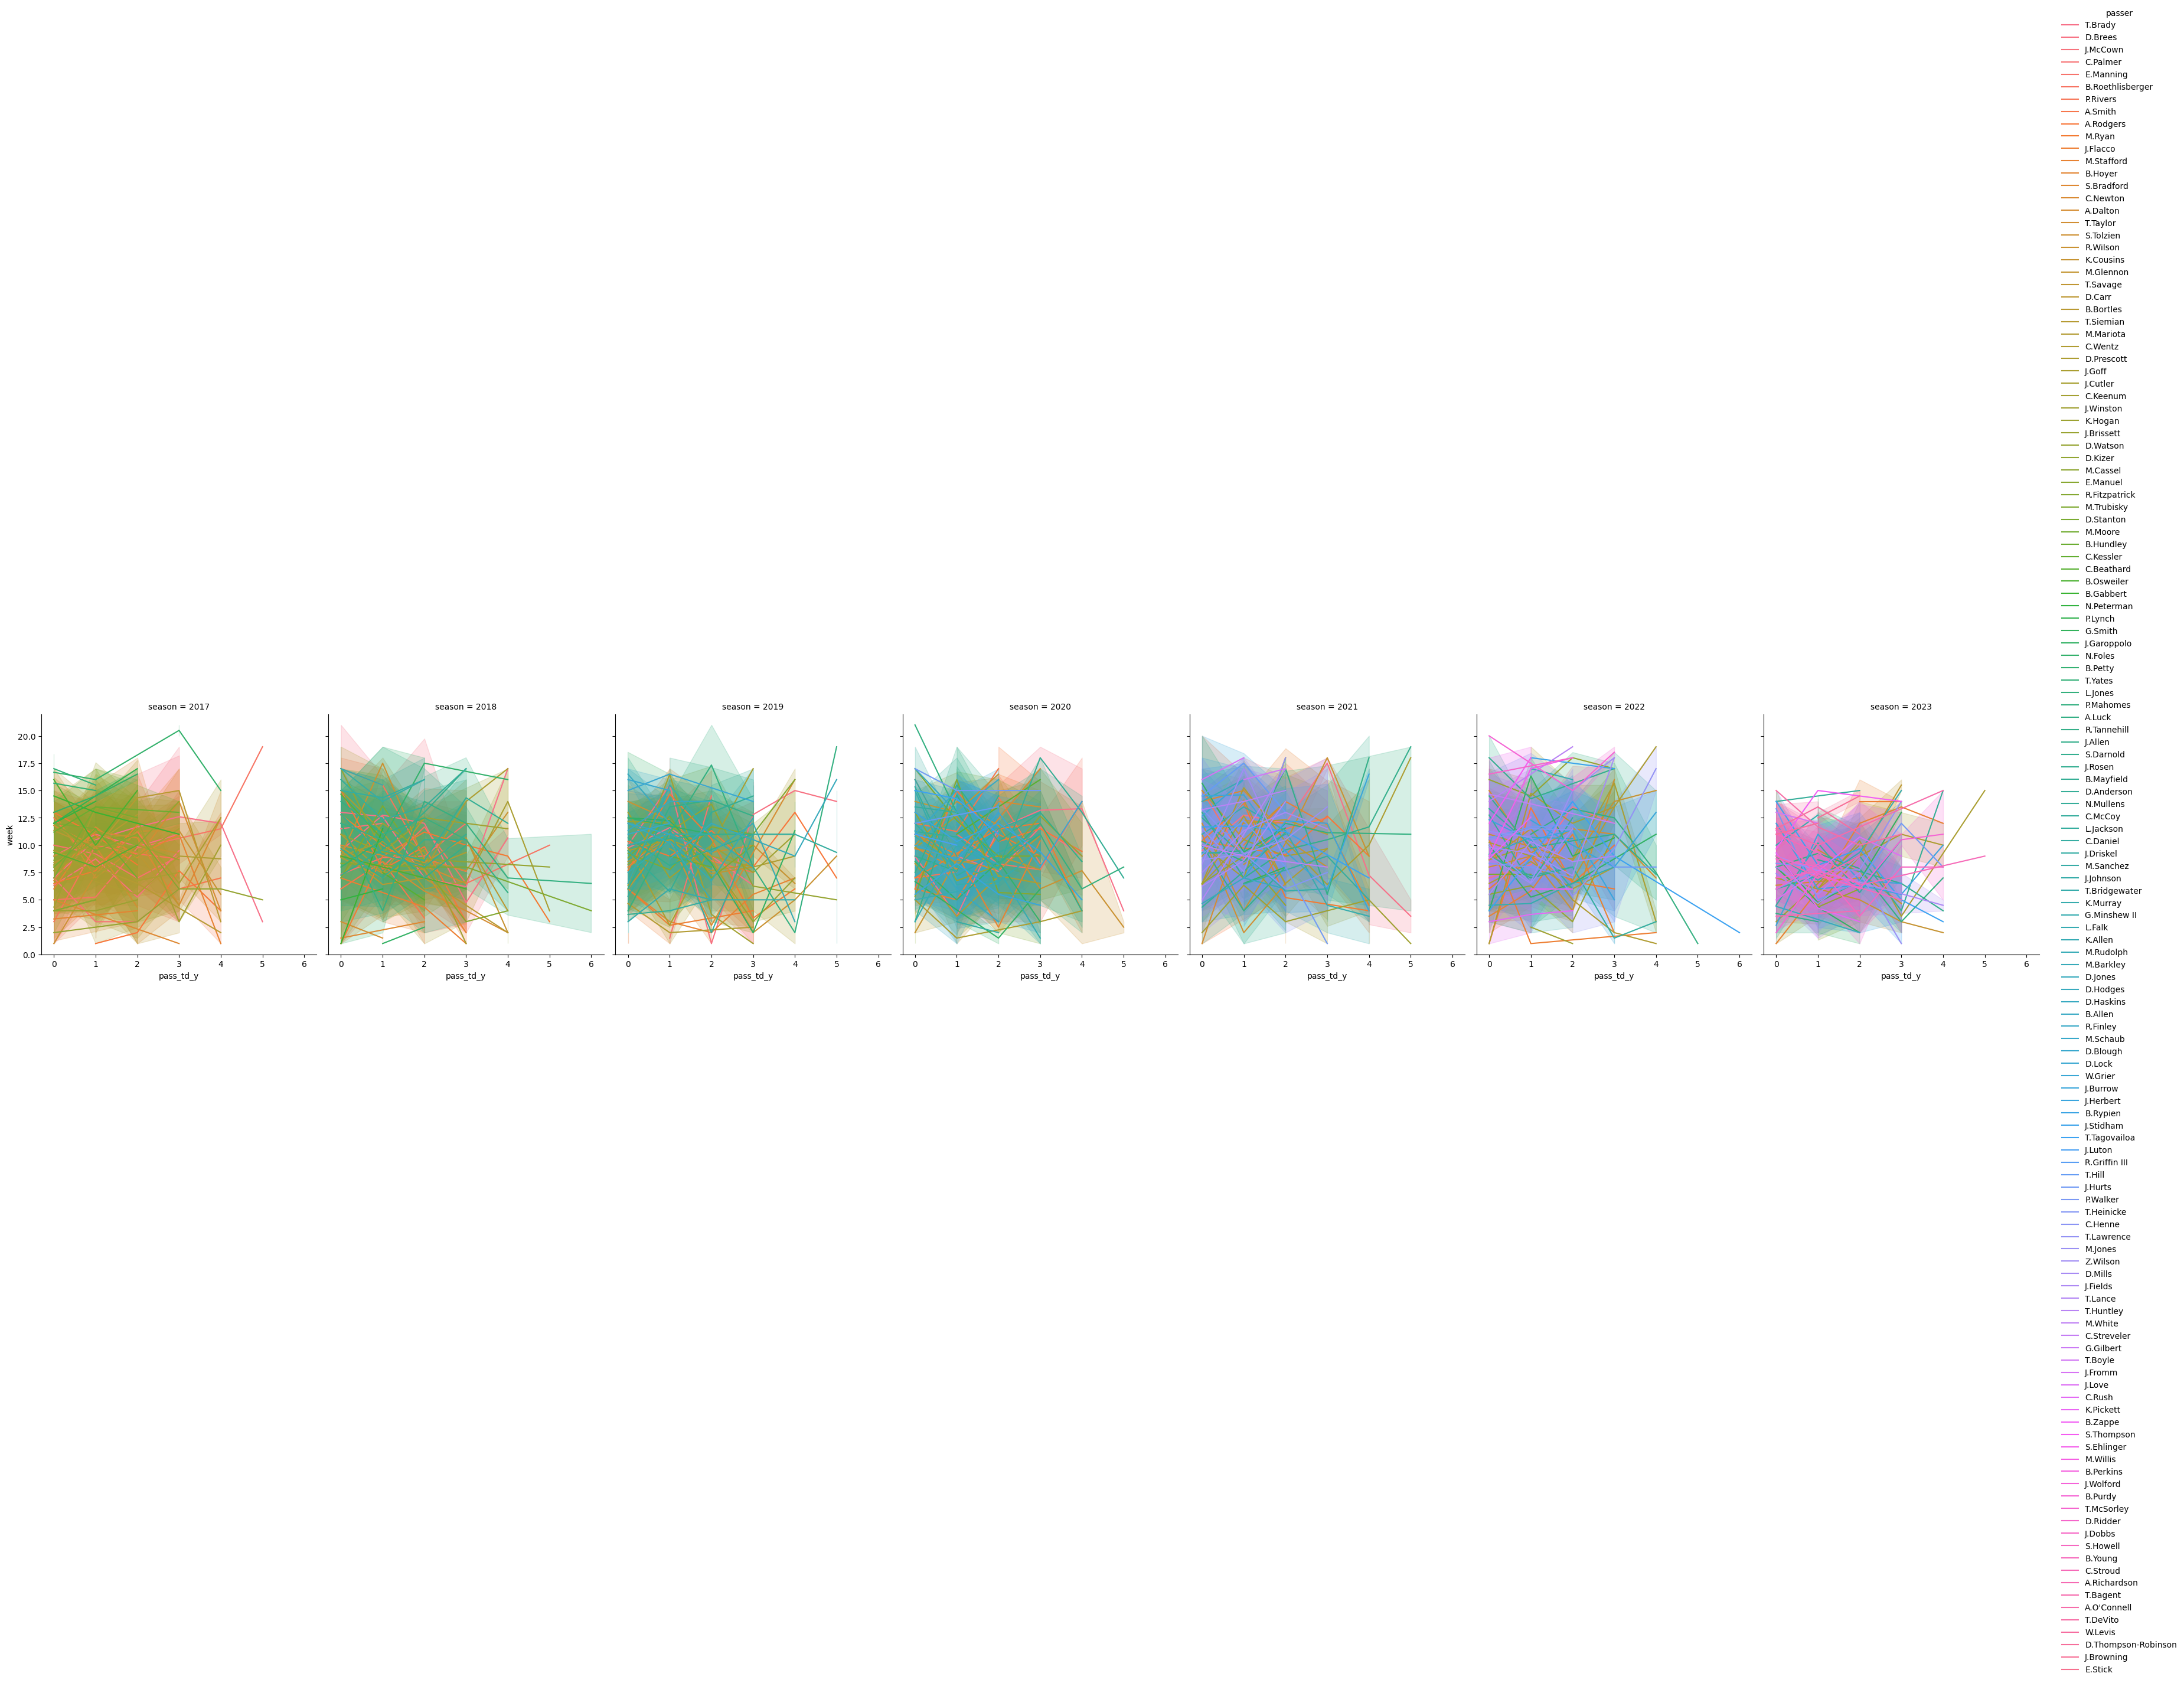

In [ ]:
sns.relplot(data=pbp_py_pass_td_y_geq10, x="pass_td_y", y="week", col="season", kind="line", hue="passer")

In [ ]:
# no pattern is clear in the above graphs. Use a model
pass_fit_py = smf.glm(formula="pass_td_y ~ pass_td_rate + total_line",
                      data=pbp_py_pass_td_y_geq10, family=sm.families.Poisson()).fit()

pbp_py_pass_td_y_geq10["exp_pass_td"] = pass_fit_py.predict()

print(pass_fit_py.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              pass_td_y   No. Observations:                 3756
Model:                            GLM   Df Residuals:                     3753
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5516.8
Date:                Sun, 24 Dec 2023   Deviance:                       3855.2
Time:                        02:14:30   Pearson chi2:                 3.22e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07269
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.0278      0.138     -7.473   

In [ ]:
# for the Poisson regression, coefficients are on an exponential scale
# access the model's parameters and take the exponent using numpy
np.exp(pass_fit_py.params)

Intercept       0.357795
pass_td_rate    1.354609
total_line      1.020814
dtype: float64

Interpreting the above parameters, for each coefficient:
- multiply every add'l TD pass in the player's history by 1.35 to get the expected # of TD passes
- multiply the total line by 1.02 (the total line is very efficient - within 2%)

In [ ]:
# look at Mahomes data from Super Bowl LVII

# specify the filter criteria
filter_by = 'passer == "P.Mahomes" & season == 2022 & week == 22'

# specify columns
cols_look = ["season", "week", "passer", "total_line", "n_games",
             "pass_td_rate", "exp_pass_td"]

pbp_py_pass_td_y_geq10.query(filter_by)[cols_look]

,season,week,passer,total_line,n_games,pass_td_rate,exp_pass_td
3295,2022,22,P.Mahomes,51.0,39,2.384615,2.109767


Explanations:

- n_games: shows total of 39 games (21 from 2022 season & 18 from prev season) in the Mahomes sample being considered
- pass_td_rate: current avg # of TD passes per game by Mahomes in the sample being considered
- exp_pass_td: the expected # of TD passes from the model for Mahomes in the Super Bowl

The avg doesn't really tell us much. It's < 2.5, but the betting market already makes < 2.5 the favorite outcome. The question we're trying to ask is: "Is it too much or too little of a favorite?". To do this, you can use exp_pass_td as Mahomes' lambda value and compute these probabilities explicitly using the prob mass function and cumulative density function.

PMF gives you the probability of a discrete event occuring, assuming a statistical distribution. With our example, this is the probability of a passer completing a single number of TD passes per game.

CDF gives you the sum or the probability of multiple events occuring, assuming a statistical distribution. With our example, this would be the probability of completing X or fewer TD passes. For example, using X=2, this would be the probability of zero, one, and two TD passes in a given week.

In [ ]:
# use poisson.pmf() and poisson.cdf()
pbp_py_pass_td_y_geq10["p_0_td"] = poisson.pmf(k=0, mu=pbp_py_pass_td_y_geq10["exp_pass_td"])
pbp_py_pass_td_y_geq10["p_1_td"] = poisson.pmf(k=1, mu=pbp_py_pass_td_y_geq10["exp_pass_td"])
pbp_py_pass_td_y_geq10["p_2_td"] = poisson.pmf(k=2, mu=pbp_py_pass_td_y_geq10["exp_pass_td"])
pbp_py_pass_td_y_geq10["p_g2_td"] = 1 - poisson.cdf(k=2, mu=pbp_py_pass_td_y_geq10["exp_pass_td"])

In [ ]:
# specify the filter criteria
filter_by = 'passer == "P.Mahomes" & season == 2022 & week == 22'

# specify columns
cols_look = ["passer", "total_line", "n_games", "pass_td_rate", "exp_pass_td",
             "p_0_td", "p_1_td", "p_2_td", "p_g2_td"]

pbp_py_pass_td_y_geq10.query(filter_by)[cols_look]

,passer,total_line,n_games,pass_td_rate,exp_pass_td,p_0_td,p_1_td,p_2_td,p_g2_td
3295,P.Mahomes,51.0,39,2.384615,2.109767,0.121266,0.255843,0.269885,0.353005


Estimation:

35.3% Mahomes throw > 3 pass TD, which is under the 40% needed to bet the over. 40% is the break-even probability given +150 pass TD prop bet of 2.5 TD passes. Calculated: 100 / (100 + 150) = 0.4

In [ ]:
0.121266+0.255843+0.269885

0.646994

64.7% just barely falls short of the 64.9% break-even point of 2 or less TD passes. Calculated: 185 / (100 + 185) = 0.649

### Poisson Regression Coefficients
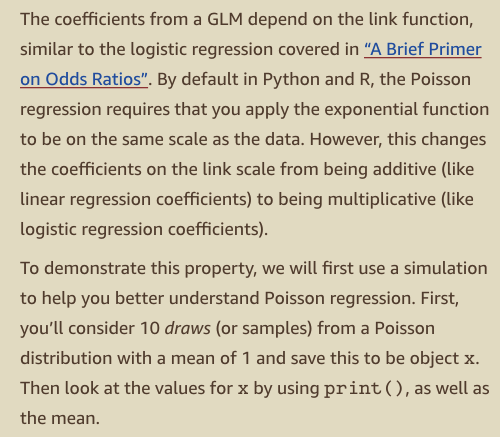

In [ ]:
from scipy.stats import poisson
x = poisson.rvs(mu=1, size=10)
print(x)
print(x.mean())

[0 1 0 0 2 0 0 0 1 0]
0.4


In [ ]:
# fit GLM w/ global intercept & look at the coefficient on the model scale &
# exponential scale

# create df for GLM
df_py = pd.DataFrame({"x": x})

# fit GLM
glm_out_py = smf.glm(formula="x ~ 1", data=df_py, family=sm.families.Poisson()).fit()

# look at output on model scale
print(glm_out_py.params)

# look at output on exponential scale
print(np.exp(glm_out_py.params))

Intercept   -0.916291
dtype: float64
Intercept    0.4
dtype: float64


In [ ]:
# Does the avg (or expected) # of TD per game change through the season?
# Baltimore QB injured during game 13

# subset the data
bal_td_py = (pbp_py.query('posteam == "BAL" & season == 2022')\
                    .groupby(["game_id", "week"]).agg({"touchdown": ["sum"]}))

# reformat the columns
bal_td_py.columns = list(map("_".join, bal_td_py.columns))
bal_td_py.reset_index(inplace=True)

# shift week so intercept 0 = week 1
bal_td_py["week"] = bal_td_py["week"] - 1

# create list of weeks for plot
weeks_plot = np.linspace(start=0, stop=18, num=10)
weeks_plot

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.])

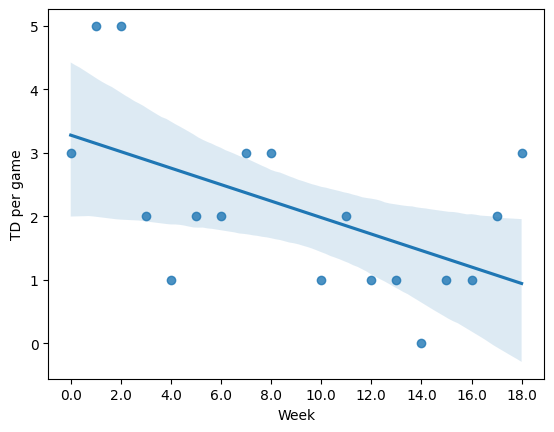

In [ ]:
# plot
ax = sns.regplot(data=bal_td_py, x="week", y="touchdown_sum")
ax.set_xticks(ticks=weeks_plot, labels=weeks_plot)
plt.xlabel("Week")
plt.ylabel("TD per game")
plt.show()

In [ ]:
# look at coefficients
glm_bal_td_py = smf.glm(formula="touchdown_sum ~ week", data=bal_td_py,
                        family=sm.families.Poisson()).fit()
# coefficients on link (or log) scale
print(glm_bal_td_py.params)

Intercept    1.253350
week        -0.063162
dtype: float64


In [ ]:
# exponential (or data) scale
print(np.exp(glm_bal_td_py.params))

Intercept    3.502055
week         0.938791
dtype: float64


While the link-scale values do not appear to provide much context, the exponential coefficients are easier to understand.

- the intercept is the # of expected passes during the first game (3.502). We adjusted week 1 to be 0 so it would be the intercept
- for the next week, you would multiply the intercept by the week raised to the exponent of (week - 1).